# Import libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow import TensorShape
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, save_model, model_from_json
from tensorflow.keras.losses import mse, binary_crossentropy, categorical_crossentropy, kullback_leibler_divergence
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Nadam

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA


from contextlib import nullcontext
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime
import sys
import xmltodict
import multiprocessing

from itertools import combinations 
from datetime import datetime

#np.random.seed(1)
#tf.random.set_seed(2)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

## Load config file 

In [2]:
data_config_file = "data\\generated_data\\spikeforest\\hybrid_janelia\\data_config.xml"#"config\\data_config.xml"

with open(data_config_file) as fd:
    data_config = xmltodict.parse(fd.read())
    data_config = data_config["data"] 
    
## load the training config file in the future instead global parameters below

# Global parameters

In [3]:
## Network parameter(s)
batch_size = 256
global_dropout = .5
lstm_dropout = 0.5
conv_dropout = 0.5
# image_shape = [32,32,4,1] # For Conv3D
image_shape = [int(data_config["timespan"]),128] 

use_multi_gpu = False
only_binary_labels = False
only_positives = True

## Loss parameters
alpha = 1024 # reconstruction loss constant ( this is usually the input image size )
beta = 15 # for the B-VAE
delta = 2 # for the binary crossvalidation
theta = 1 # for the cluster closeness  
ce_eq = 1# for equalizing the cross_entropy loss 

## Latent parameters
latent_dim = 64
upper_latent_dim = 8


tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True) 
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[1], True)  
## Training parameter(s)

epochs = 200
validation_freq= 5
cluster_update_interval = 10 # per epochs  
target_dist = []

load_VAE_from_file = True
fine_tune_detector = True # if fine tune is True we will load the detector weights
train_only_detector = False  # this trains the detector only
load_only_encoder = False
load_full_model = True

use_clustering = False
train_detector = True or train_only_detector # cce is valid_loss ?
use_reconstruction_loss = True

max_clusters = int(data_config["max_clusters"])+1 # cluster number
if only_binary_labels:
    max_clusters = min(max_clusters, 2)
#Step parameters
training_steps = int(int(data_config["train"]["samples"]) / batch_size) #32 ## number of samples in training dataset = 189898
validation_steps = int(int(data_config["val"]["samples"]) / batch_size) # 
test_steps = int(int(data_config["test"]["samples"]) / batch_size)

## Visualization parameter(s)
epoch_per_visualization = 25
step_per_visualization = 500

filter_train_to_ratio = True
## Fine tuning options 
                
pretrained_model_path = "trained_models\\spikeforest\\hybrid_janelia\\pre_trained_vae_"#"trained_models\\pre_trained_vae_"
full_model_path = "trained_models\\spikeforest\\hybrid_janelia\\vae_model.h5"

# Define parsing function 

In [4]:
def parse_fn(proto):
    features = {'image': tf.io.FixedLenFeature([], tf.string), 'label': tf.io.FixedLenFeature([], tf.string)}

    parsed_features = tf.io.parse_single_example(proto, features)
    images = tf.io.decode_raw(parsed_features['image'], tf.int16)

    
    labels = tf.io.decode_raw(parsed_features['label'], tf.int32)
    #labels = tf.cast(labels, tf.int32)
    labels = tf.reshape(labels, (max_clusters,))


    if only_binary_labels:

        labels = tf.cast(labels, tf.int32)
        labels = tf.math.minimum(labels, 1)
        labels = tf.one_hot(labels, depth=2)

    else:
        if max_clusters == 2:
            labels = tf.math.minimum(labels, 1)

    images = tf.reshape(images, image_shape)

    images = tf.cast(images, tf.float32)

    images = (images / tf.math.reduce_max(images))

    return (images,labels), (images, labels, labels, [0], [0])

# Define dataset reader

In [5]:
from tensorflow.python.framework import ops

def resampler_class_func(initial_rate, target_rate=50.):
    
    initial_rate = ops.convert_to_tensor(initial_rate, name="initial_rate")
    target_rate = ops.convert_to_tensor(target_rate, name="target_rate")

    rate = target_rate / initial_rate # 25 
    prob_rate = 1.0 / rate
    
    
    if initial_rate > 50.:
        prob_rate = 1.0
    
    def _map_fn(data, label):
        
        label = tf.argmax(data[1])
        label= tf.cast(label, tf.float32)
        random_num = tf.random.uniform(shape=[1])
        
        bin_layer = tf.math.reduce_min([label,1])
        
        prob_rate_for_sample = [(1-bin_layer)*prob_rate] + bin_layer
    
        if random_num <= prob_rate_for_sample:
            return True
        
        return False
        
    
    return _map_fn

def random_flip_left_right( data, label):

    img, label = data
    img = tf.expand_dims(img, -1)
    img_flipped = tf.image.random_flip_left_right(img, 5)
    img_flipped = tf.squeeze(img_flipped, -1)
    
    return (img_flipped, label), (img_flipped, label, label, [0], [0])

def only_positive_filter():

    def _map_fn(data, label):

        return tf.argmax(label[1]) > 0

    return _map_fn
    
def get_dataset(fname, samples=4096, pos_rate=None):
    
    samples = int(samples) # 
    training_file = os.path.join(data_config["dir"],fname)

    # Build an iterator over training batches.
    training_dataset = tf.data.TFRecordDataset(training_file)

    training_dataset = training_dataset.map(parse_fn, num_parallel_calls=3)
    
    #if max_clusters > 2:
    #    raise ValueError("Warning! If you have multiple clusters, you will get poor model performance if you augment data with max_clusters > 2. To fix this put only_binary_labels = True at the constructor of DatasetLoader")
    
    #training_dataset = training_dataset.map(random_flip_left_right, num_parallel_calls=6)
    
    if pos_rate is not None and filter_train_to_ratio:
        training_dataset = training_dataset.filter(resampler_class_func(pos_rate)) 
        
    if only_positives and max_clusters > 2 and not only_binary_labels:
        training_dataset = training_dataset.filter(only_positive_filter())

    
    training_batches = training_dataset.take(samples).shuffle(8192, reshuffle_each_iteration=True).batch(batch_size).prefetch(min(1024, batch_size*4)).cache()
    
    #sample = tf.reshape(sample, shape=image_shape)
    
    return training_batches

### GoogLeNet

In [8]:
def lenet(input, filter):
    x3 = Conv2D(filter, kernel_size=3, padding="same", activation="relu")(input)
    x5 = Conv2D(filter, kernel_size=5, padding="same", activation="relu")(input)
    x1 = Conv2D(filter, kernel_size=1, padding="same", activation="relu")(input)

    concat = Concatenate(axis=-1)([x1,x3,x5])

    return Conv2D(filter, kernel_size=1, padding="same", activation="relu")(concat)

## ClusteringLayer

In [10]:
class ClusteringLayer(Layer):

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
    
    def call(self, inputs, **kwargs):

        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        
        
        return q  

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## KL Divergence Layer

In [11]:
class KLDivergenceLayer(Layer):

    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(**kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(beta * K.mean(kl_batch), inputs=inputs)

        return inputs

    def get_config(self):
        return {}
    
    def from_config(cls, config):
        return cls()

## Latent Layer 

In [12]:
class LatentLayer(Layer):

    def __init__(self, **kwargs):
        super(LatentLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        super(LatentLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #print(x)
        #assert isinstance(x, list)
        
        z_mean, z_log_var = x
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        
        
        z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])
        
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        shape_a, shape_b = input_shape
        return shape_a
    
    def get_config(self):
        return {}
    
    def from_config(cls, config):
        return cls()
    def from_config(config):
        return LatentLayer()
    

# Define the classificator auxiliary branch 

In [13]:
def aux_classificator(input_shape=latent_dim+upper_latent_dim):
    inputs = Input(shape=(input_shape,), name='latent_dim_detector_input')

    x = Dropout(global_dropout)(inputs)
    x = Dense(512, activation="relu")(x)
    x = Dropout(global_dropout)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(global_dropout)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(global_dropout)(x)
    x = Dense(64, activation="relu")(x)
    
    x = Dense(max_clusters, activation="sigmoid")(x)
    classificator = Model(inputs, x, name='detection')
    
    return classificator

# Define the encoder

In [14]:
def encoder_model(inputs):
    
    x = Reshape((image_shape[0]*image_shape[1],))(inputs)
    x = BatchNormalization()(x)
    x = Reshape((image_shape[0], image_shape[1]))(x)
    
    normalized_input = x
    
    
    #"""
    conv_x = Reshape((image_shape[0], 4, 32))(x)

    conv_x = tf.transpose(conv_x, perm=[0, 3, 2, 1])

    conv_x = lenet(conv_x, 32)
    
    conv_x = Dropout(conv_dropout)(conv_x)
    
    conv_x = lenet(conv_x, 64)
    
    conv_x = Dropout(conv_dropout)(conv_x)

    conv_x = Conv2D(64, kernel_size=2, padding="valid", activation="relu")(conv_x)

    conv_x = lenet(conv_x, 128)
    
    conv_x = Dropout(conv_dropout)(conv_x)

    conv_x = Conv2D(128, kernel_size=2, padding="valid", activation="relu")(conv_x)

    conv_x = lenet(conv_x, 256)

    conv_x = Dropout(conv_dropout)(conv_x)
    
    conv_x = Flatten()(conv_x)
    #"""
    
    
    blstm = Bidirectional(LSTM(128, return_sequences=True, dropout=lstm_dropout))(x)
    
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=lstm_dropout))(blstm)
    x = Attention()([blstm, x])
    
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=lstm_dropout))(x)
    
    blstm = Bidirectional(LSTM(64, return_sequences=True, dropout=lstm_dropout))(x)
    x = Attention()([blstm, x])
    
    x = Bidirectional(LSTM(32, return_sequences=True, dropout=lstm_dropout))(x)
    
    
    
    x = Flatten()(x)
    
    x = Concatenate(axis=1)([x, conv_x])
    x = Dense(latent_dim*2, activation='relu')(x)

    
    #x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    z = LatentLayer()([z_mean, z_log_var])
       
    # 
    # Upper latent encoding 
    #
    
    upper_z = Dense(16, activation="relu")(z)
    
    
    upper_z = BatchNormalization()(upper_z)
    upper_mean = Dense(upper_latent_dim, name="upper_mean")(upper_z)
    upper_log_var = Dense(upper_latent_dim, name="upper_log_var")(upper_z)
    
    upper_z = LatentLayer()([upper_mean, upper_log_var])
    
    
    final_z = Concatenate(axis=1, name="final_z_layer")([z,upper_z])
    # We need to concatenate the mean and the std also so we can calc the gradients for the upper latents aswell
    final_z_mean = Concatenate(axis=1)([z_mean, upper_mean])    
    final_z_log_var = Concatenate(axis=1)([z_log_var, upper_log_var])

    
    
    encoder = Model(inputs, final_z, name='encoder')
    #encoder.summary()

    return encoder, final_z

# Define the decoder

In [15]:
def decoder_model(input_shape=latent_dim+upper_latent_dim):
    
    latent_inputs = Input(shape=(input_shape,), name='z_sampling')
    
    first_dense_size = 32
    
    x = Dense(image_shape[0]*image_shape[1], activation='relu')(latent_inputs)
    #x = Dropout(rate=0.2)(x)
    x = Reshape((image_shape[0], image_shape[1]))(x)
    
    x = Bidirectional(LSTM(32, return_sequences=True, dropout=lstm_dropout))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=lstm_dropout))(x)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=lstm_dropout))(x)
    
    blstm = Bidirectional(LSTM(128, return_sequences=True, dropout=lstm_dropout))(x)
    x = Attention()([x, blstm])
    
    outputs = LSTM(128, return_sequences=True, dropout=lstm_dropout)(x)

    outputs = Reshape((image_shape[0], image_shape[1]))(outputs)
    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='reconstruction')
    #decoder.summary()
    
    return decoder

# Load the datasets

In [16]:
train_dataset = get_dataset("train.tfrecord", samples=data_config["train"]["samples"], pos_rate=float(data_config["train"]["ratio"]))
val_dataset = get_dataset("val.tfrecord", samples=data_config["val"]["samples"])
test_dataset = get_dataset("test.tfrecord", samples=data_config["test"]["samples"])


## Recall, Precision and F1

In [17]:
def calcF1Score(data, steps, mode="micro"): # or macro or weighted or all
    iterator = tf.compat.v1.data.make_one_shot_iterator(data)
    y_t = []
    y_p = []
    for s in range(steps):

        gt = iterator.get_next()
        batch_im = gt[0]
        y_true = gt[1][1]

        output, y_pred, _, _, _ = vae.predict(batch_im, steps=1)

        y_t.extend(y_true)
        y_p.extend(y_pred)

    y_t = np.asarray(y_t)
    y_p = np.asarray(y_p)
    y_t = np.argmax(y_t, axis=1)
    y_p = np.argmax(y_p, axis=1)
    
    if mode == "all":
        
        mic = f1_score(np.asarray(y_t), np.asarray(y_p), average="micro")
        mac = f1_score(np.asarray(y_t), np.asarray(y_p), average="macro")
        wei = f1_score(np.asarray(y_t), np.asarray(y_p), average="weighted")
        
        print("F1 micro: "+str(mic))
        print("F1 macro: "+str(mac))
        print("F1 weighted: "+str(wei))
        
        return mic, mac, wei
    
    res = f1_score(np.asarray(y_t), np.asarray(y_p), average=mode)
    print("F1 "+mode+": "+str(res))
    return res

def calcCompletness(data, steps): # or macro or weighted
    iterator = tf.compat.v1.data.make_one_shot_iterator(data)
    y_t = []
    y_p = []
    for s in range(steps):

        gt = iterator.get_next()
        batch_im = gt[0]
        y_true = gt[1][1]

        output, y_pred, _, _,_ = vae.predict(batch_im, steps=1)

        y_t.extend(y_true)
        y_p.extend(y_pred)

    y_t = np.asarray(y_t)
    y_p = np.asarray(y_p)
    y_t = np.argmax(y_t, axis=1)
    y_p = np.argmax(y_p, axis=1)
    
    homogeneity, completness, vmes = homogeneity_completeness_v_measure(y_t, y_p)
    print("Completness: : "+str(completness))
    print("homogeneity: : "+str(homogeneity))
    print("V measure: : "+str(vmes))
    return homogeneity, completness, vmes

def calcEverything(data, steps):
    y_t = []
    y_p = []
    
    output, y_p, _, _,y_t = vae.predict(data, steps=steps)


    y_t = np.asarray(y_t)
    y_p = np.asarray(y_p)
    y_t = np.argmax(y_t, axis=1)
    y_p = np.argmax(y_p, axis=1)
    
    mic = f1_score(np.asarray(y_t), np.asarray(y_p), average="micro")
    mac = f1_score(np.asarray(y_t), np.asarray(y_p), average="macro")
    wei = f1_score(np.asarray(y_t), np.asarray(y_p), average="weighted")
        
    print("F1 micro: "+str(mic))
    print("F1 macro: "+str(mac))
    print("F1 weighted: "+str(wei))
    
    homogeneity, completness, vmes = homogeneity_completeness_v_measure(y_t, y_p)
    print("Completness: : "+str(completness))
    print("homogeneity: : "+str(homogeneity))
    print("V measure: : "+str(vmes))
    
    return mic, mac, wei, completness, homogeneity, vmes

def calcRecallPrecision(data, steps):
    iterator = tf.compat.v1.data.make_one_shot_iterator(data)

    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for s in range(steps):

        gt = iterator.get_next()
        batch_im = gt[0]
        y_true = gt[1][1]

        output, y_pred, _, _,_ = vae.predict(batch_im, steps=1)

        for b in range(batch_size):
            if y_true[b][0] == np.round(y_pred[b][0]):
                if y_true[b][0] == 1:
                    tn +=1
                else:
                    tp +=1
            else:
                if y_true[b][0] == 1:
                    fp += 1
                else:
                    fn += 1
                
    print ((tp, tn, fp, fn))
    return (100*tp/(fn+tp+sys.float_info.epsilon), 100*tp/(fp+tp+sys.float_info.epsilon))
    
    

## Define the custom losses

In [18]:
def vae_loss(valid_loss = True):
    def loss(original, reconstructed):
        
        reconstruction_loss = mse(K.flatten(original), K.flatten(reconstructed))
        reconstruction_loss *= alpha

        if not valid_loss:
            return 0.

        return K.mean(reconstruction_loss)

    return loss

def custom_crossentropy(use_delta=True, valid_loss = True):
    def loss(y_true, y_pred):
        if not valid_loss:
            return 0.
        cce = categorical_crossentropy(y_true, y_pred)
        
        loss_ = ce_eq * (1-y_true[:,0])* cce + y_true[:,0]*cce 
        
        if use_delta:
            loss_ = delta * loss_
            
            
        return loss_

    return loss

def zero_loss(y_true, y_pred):
    return 0.

def cluster_loss(use_theta = True, valid_loss = True):
    
    def loss(y_true, layer_output):
        
        if not valid_loss:
            return 0.
        
        if use_theta:
            layer_output = theta * kullback_leibler_divergence(y_true, layer_output)
        
        return layer_output
    
    return loss
        

In [19]:

def custom_loss_to_load(use_vae_loss = True, use_detector_loss = True):
    def loss(y_true, y_pred):
        if y_true.shape[-1] == 2:
            if use_detector_loss:
                return custom_crossentropy(use_delta=use_vae_loss)(y_true, y_pred)
            else:
                return 0.
        else:
            if use_vae_loss:
                return vae_loss()(y_true, y_pred)
            else:
                return 0.
    return loss

# Define and Compile model

In [20]:
optimizer = Adam(learning_rate = 0.001)

def build_model(load_weights = False, freeze_ae=False):
    
    
    if use_multi_gpu:
        
        cross_device_ops = tf.distribute.HierarchicalCopyAllReduce(num_packs=1)
        
        mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=cross_device_ops).scope()
    else:
        mirrored_strategy = nullcontext()
        mirrored_strategy = tf.device('/gpu:0')
    
    with mirrored_strategy:
        inputs = Input(image_shape, name="input")

        inputs_aux = Input((max_clusters,), name="input_labels")

        encoder, latent_layer = encoder_model(inputs)
    
        decoder = decoder_model()
    
        if load_weights:
            
            encoder.load_weights(pretrained_model_path+"encoder.h5") 
            if not load_only_encoder:
                decoder.load_weights(pretrained_model_path+"decoder.h5")
        
        outputs = decoder(latent_layer)
        
    
        if freeze_ae:
            encoder.trainable = False
            if not load_only_encoder:
                decoder.trainable = False

            beta = 0.
    
        detector = aux_classificator()
    
        if fine_tune_detector:
            detector.load_weights(pretrained_model_path+"detector.h5")
        
        detector_output = detector(latent_layer)

    
        cluster_output = ClusteringLayer(max_clusters, name="clustering")(latent_layer)

        vae = Model([inputs, inputs_aux], [outputs, detector_output, cluster_output, latent_layer, inputs_aux], name='vae')
        vae.compile(optimizer=optimizer, metrics={"detection":["accuracy"]}, loss=[vae_loss(valid_loss=(not freeze_ae or load_only_encoder or use_reconstruction_loss)), custom_crossentropy(use_delta = (not freeze_ae or load_only_encoder), valid_loss=train_detector), cluster_loss(valid_loss=use_clustering), zero_loss, zero_loss])

    vae.summary()
    
    return vae, encoder, decoder, detector

### Load/build model if its the case

In [21]:
if load_VAE_from_file:
    K.clear_session()
    if load_full_model:
        vae = load_model(full_model_path, custom_objects={"ClusteringLayer":ClusteringLayer, "LatentLayer":LatentLayer, "AttentionLayer":AttentionLayer, "loss":custom_loss_to_load(), "zero_loss":custom_loss_to_load()})
    else:
        if train_only_detector: # load the model, the loss will be calculated only for the detector
            vae, encoder, decoder, detector = build_model(load_weights = True, freeze_ae = True)
        
        elif use_clustering:
            vae, encoder, decoder, detector = build_model(load_weights = True, freeze_ae = False)
        else: # load the entire model with loss being applied to all of the outputs
            vae, encoder, decoder, detector = build_model(load_weights = True)
else: 
    vae, encoder, decoder, detector = build_model()

# Defining custom callbacks

### Show Images callback

In [23]:
class ShowImages(tf.keras.callbacks.Callback):

  def __init__(self, data, time_dim_ = False):
    self.data = data 
    self.time_dim = time_dim_

    
  def on_epoch_begin(self, epoch, logs=None):
    return
    #print('\nTraining: epoch {} begins at {}'.format(epoch, datetime.datetime.now().time()))

  def on_train_end(self, logs=None):
    self.on_epoch_end(0)
    return
  
  def on_epoch_end(self, epoch, logs=None):
    
    current_epoch = epoch
    if(epoch != 0 and (epoch+1) % epoch_per_visualization != 0):
        return
    
    iterator = tf.compat.v1.data.make_one_shot_iterator(self.data)
    try:
        gt = iterator.get_next()
    except Exception:
        return
    
    im = gt[0]
    label = gt[1][1]
    
    #im_norm, output = vae.predict(im, steps=1)
    output, detected, latent_layer, _, _= vae.predict(im, steps=1)
    im_norm = im[0]
    
    num_to_plot = 10
    fig=plt.figure(figsize=(num_to_plot, 12))
   
    if(self.time_dim):
        
        # Plotting in time dimension 
        print (tf.keras.backend.get_value(label))
        for i in [np.argmax(tf.keras.backend.get_value(label)[:, 1])]:#range(num_to_plot):
            orig = im_norm[0,:,i]
            predicted = output[0,:,i]

            fig.add_subplot(num_to_plot, 2, 2*i+1)
            plt.title("GT")
            plt.plot(orig)
            bottom, top = plt.ylim()

            fig.add_subplot(num_to_plot, 2, 2*i+2)
            plt.title("PR")
            plt.plot(predicted)
            plt.ylim(bottom, top)

        plt.subplots_adjust(hspace=0.2)
        plt.subplots_adjust(wspace=1)
        plt.show()

    else:
        
        # Plotting in space dim
        
        for i in range(num_to_plot):
            #if tf.keras.backend.get_value(label[i][1]) != 1 and round(detected[i][1]) != 1:
            #    continue
            orig = im_norm[i] # FOR CONV3D: +1 dim HERE
            predicted = output[i] # FOR CONV3D: +1 dim HERE
            
            
            fig.add_subplot(num_to_plot, 2, 2*i+1)
            
            if max_clusters == 2:
                plt.title("Ground truth, AP="+str(tf.keras.backend.get_value(label[i])))
            else:
                plt.title("Ground truth")
                
            plt.imshow(orig)
            cbar = plt.colorbar(aspect=5)
            cbar.ax.get_yaxis().set_ticks([0,1])
            
            vmin = np.min(orig)
            vmax = np.max(orig)
            fig.add_subplot(num_to_plot, 2, 2*i+2)
            if max_clusters == 2:
                plt.title("Channel nr."+str(i+1)+" predicted, AP="+str([ '%.2f' % elem for elem in detected[i]]) )
            else:
                plt.title("Predicted")
            plt.imshow(predicted, vmin=vmin, vmax=vmax)
            cbar = plt.colorbar(aspect=5)
            cbar.ax.get_yaxis().set_ticks([0,1])

        plt.subplots_adjust(hspace=1)
        plt.show()
    
    return
    #print('\nTraining: epoch {} ends at {}'.format(epoch, datetime.datetime.now().time()))


## Update clusters

In [24]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [25]:
class UpdateClusters(tf.keras.callbacks.Callback):

    def __init__(self, data, iter_num = training_steps):
        self.data = data 
        self.iter_num = iter_num
        self.n_clusters = max_clusters
    def on_epoch_end(self, epoch, logs=None):
        
        if not use_clustering:
            return
        
        if epoch % cluster_update_interval != 0:
            return
            
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        
        _, _, _, latent,_ = vae.predict(train_dataset, steps=200) # for large datasets we need to limit 
        
        kmeans.fit(latent)
        
        vae.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
                

## Beta-scheduler

In [26]:
class BetaScheduler(tf.keras.callbacks.Callback):

    def __init__(self, low = -2, high = 2, freq = 20, enabled=True):
        self.low = low 
        self.high = high
        self.freq = freq
        self.use_scheduler = enabled
        
    def on_epoch_end(self, epoch, logs=None):
        
        if not self.use_scheduler:
            return
        
        inside_step = epoch % self.freq
        
        if inside_step < self.freq //2:
            beta = (self.high/((self.freq//2)**2))*inside_step*inside_step
        else:
            beta = self.high
        
        if epoch % self.freq != 0:
            return
            
                

## Testing the plotting 

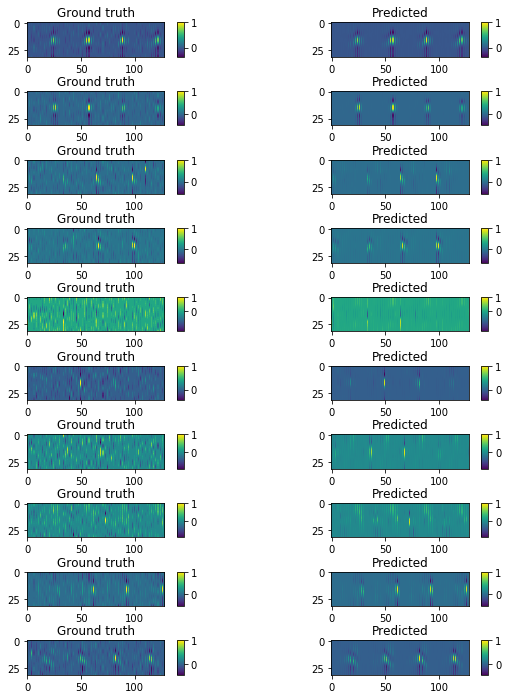

In [27]:
#%matplotlib qt
si = ShowImages(test_dataset, time_dim_=False)
si.on_epoch_end(0)

if False:
    for i in range(20):
        si.on_epoch_end(0)

# Visualizing learning curve

In [28]:
def ViewHistory(history_key, minimal=True):
    #%matplotlib inline
    
    val_history = []
    #print(history.history['val_'+history_key])
    for val in history.history['val_'+history_key]:
        
        val_history.extend(validation_freq*[val])
        
    val_history.extend((len(history.history[history_key]) % validation_freq)*[history.history['val_'+history_key][-1]])
    
    # Plot training & validation loss values
    plt.plot(history.history[history_key])
    plt.plot(val_history)

    if minimal:
        best_loss = min(history.history[history_key])
        argmin_loss = np.argmin(history.history[history_key])
        best_vloss = min(history.history['val_'+history_key])
        best_vloss_at_loss = val_history[argmin_loss]
    else:
        best_loss = max(history.history[history_key])
        argmax_loss = np.argmax(history.history[history_key])
        best_vloss = max(history.history['val_'+history_key])
        best_vloss_at_loss = val_history[argmax_loss]
    #plt.ylim(min(best_loss, best_vloss)-3,150)
    #plt.xlim(0,200)

    plt.title('Model '+history_key)
    plt.ylabel(history_key)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    plt.close()


    print("Best "+history_key+" was: "+str(best_loss))
    print("Validation "+history_key+" at best "+history_key+" was: "+str(best_vloss_at_loss))
    print("Validation "+history_key+" was: "+str(best_vloss))
    


# Define Fit function 

In [29]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=10, min_lr=0.00001, cooldown=5, verbose=1)

logdir = "logs\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
save_checkpoint = ModelCheckpoint("trained_models\\checkpoint\\checkpoint.hdf5", monitor='val_loss', save_best_only=True)


def fit(num_epochs):
    return vae.fit(train_dataset,
                epochs=epochs,
                steps_per_epoch=None,
                validation_data=(val_dataset, None, None),
                validation_steps=None,
                validation_freq = validation_freq,
                verbose=1,
                callbacks=[ShowImages(val_dataset), reduce_lr, UpdateClusters(train_dataset), tensorboard_callback, BetaScheduler() ],#, save_checkpoint],
                use_multiprocessing=True,
                workers=5)

# Training

In [30]:
#%matplotlib inline
#decoder.trainable = False
#detector.trainable = True
#encoder.trainable = False
vae.summary()
history = fit(epochs)
encoder.trainable = False


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 128)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 4096)         0           input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4096)         16384       reshape[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 128)      0           batch_normalization[0][0]        
________________________________________________________________________________________________

ZeroDivisionError: division by zero

In [ ]:
if not load_VAE_from_file:
    # save the weight of AE
    encoder.save_weights(pretrained_model_path+"encoder.h5")
    decoder.save_weights(pretrained_model_path+"decoder.h5")
    
detector.save_weights(pretrained_model_path+"detector.h5")

# Save model 

In [ ]:
save_model(vae, full_model_path)

## Evaluate model

In [ ]:
#vae.evaluate(test_dataset)
#vae.evaluate(val_dataset, steps=validation_steps)

## Calc Recall and Precision

In [ ]:
"""
train_recall, train_precision = calcRecallPrecision(train_dataset, training_steps)
print("Train dataset: ")
print("---- Recall: "+str(train_recall))
print("---- Precision: "+str(train_precision))
print("----------------------------------\n")
"""
"""
val_recall, val_precision = calcRecallPrecision(val_dataset, validation_steps)
print("Val dataset: ")
print("---- Recall: "+str(val_recall))
print("---- Precision: "+str(val_precision))
print("----------------------------------\n")
#"""
"""
test_recall, test_precision = calcRecallPrecision(test_dataset, test_steps)
print("Test dataset: ")
print("---- Recall: "+str(test_recall))
print("---- Precision: "+str(test_precision))
#"""

#print("\nResults for Train ")
#calcEverything(train_dataset, training_steps)

#print("\nResults for Validation ")
#calcEverything(val_dataset, validation_steps)

print("\nResults for Test ")
calcEverything(test_dataset, 100)


### Inferencing with the encoder only

In [ ]:
latents = []

import time 
t1 = time.time()
_, detection, _, latents, gt = vae.predict(train_dataset, steps=100)

runtime= time.time()-t1
print("x faster than real life: ", (batch_size*100*image_shape[0])/(20000*runtime))



#detection = detection[:,1]
#detection = [np.where(r>=0.5)[0][0] for r in detection]
#detection = np.asarray(detection)
#detection = np.round(detection)

detection = np.argmax(detection, axis=1)

non_zeros = np.count_nonzero(gt, axis=1)

gt = gt[non_zeros == 1]
latents = latents[non_zeros == 1]

gt = np.argmax(gt, axis=1)
#gt = detection # to see what was detected 

#gt = gt == detection

print("Ratio: ", len(gt[gt==1])*100/len(gt))
print(gt.shape)
print(latents.shape)
print(detection.shape)
print(detection)

In [ ]:
from mpl_toolkits import mplot3d
#%matplotlib notebook
%matplotlib qt

from sklearn.decomposition import PCA

pca = PCA(n_components=3)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=25, n_iter=300, learning_rate=50)


latents = np.nan_to_num(latents)

from numpy import inf
for l in range(len(latents)):
    
    latents[l] = np.nan_to_num(latents[l])
    latents[l][latents[l] == inf] = 0
    latents[l][latents[l] == -inf] = 0

latents = latents.astype("float64")
    
latents_pca = pca.fit_transform(latents) 
latents_pca = tsne.fit_transform(latents)
#latents_pca = latents[:,3:8]

#latents_pca = latents[:, :3]
cdict= {0:"blue", 1 :"red"}
sample_num = latents.shape[0]
print(max_clusters)
ax = plt.axes(projection='3d')
for cat in range(max_clusters):
    lat = np.where(gt[:sample_num] == cat)
    for i in range(0,latents_pca.shape[1]-1,2):
        ax.scatter3D(latents_pca[lat,i,], latents_pca[lat,i+1], latents_pca[lat,i+2], c = np.random.rand(3,))

#ax.scatter3D(latents[:sample_num,0], latents[:sample_num,1])
ax.view_init(0, 0)

## 